In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [16]:
from sklearn.datasets import load_boston

from sklearn.tree import plot_tree, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# Load data

In [7]:
data = load_boston()

In [11]:
X = data['data']
y = data['target']

In [12]:
data['feature_names']

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

# Train

In [32]:
model_dt = DecisionTreeRegressor(max_leaf_nodes=10,random_state=42)
model_dt.fit(X_train, y_train)

pred_dt = model_dt.predict(X_test)
print(mean_absolute_error(y_test, pred_dt))
print(r2_score(y_test, pred_dt))

2.8483319418325292
0.813134366573089


In [27]:
model_dt.max_features_

13

## feature importance with sklearn instance

In [21]:
model_dt.feature_importances_

array([5.12956739e-02, 3.35270585e-03, 5.81619171e-03, 2.27940651e-06,
       2.71483790e-02, 6.00326256e-01, 1.36170630e-02, 7.06881622e-02,
       1.94062297e-03, 1.24638653e-02, 1.10116089e-02, 9.00872742e-03,
       1.93328464e-01])

## feature importance with my codes

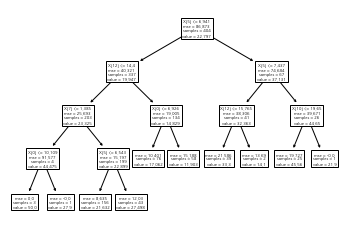

In [33]:
plot_tree(model_dt)
plt.show()

In [35]:
n = model_dt.tree_.n_node_samples[0]
fi = np.zeros(model_dt.tree_.n_features)
for idx, feat in enumerate(model_dt.tree_.feature):
    if feat<0:
        continue
    nt = model_dt.tree_.n_node_samples[idx]
    ntl = model_dt.tree_.n_node_samples[model_dt.tree_.children_left[idx]]
    ntr = model_dt.tree_.n_node_samples[model_dt.tree_.children_right[idx]]
    fi[feat] += (nt / n) * ( model_dt.tree_.impurity[idx] - (ntl / nt) * model_dt.tree_.impurity[model_dt.tree_.children_left[idx]] - (ntr / nt)* model_dt.tree_.impurity[model_dt.tree_.children_right[idx]]  )

fi_norm = fi/fi.sum()

In [36]:
np.allclose(fi_norm, model_dt.feature_importances_)

True